## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  


### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics--for simplicity we'll just use accuracy in this homework. 

For this assignment, you’ll build two models and measure their performance using the accuracy metric. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading

There are 5 graded problems, each worth 5 points, for a total of 25 points.

In [1]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from kagglehub               import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
from tqdm                    import tqdm

from collections import Counter

# globals

random_state = 42


### Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

In [2]:
# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\JT von Seggern\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1


In [3]:
# create variable for the file
file = os.path.join(path, "diabetes.csv")

# load the file into a dataframe
df = pd.read_csv(file)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Split the data into features and target
X = df.drop("Outcome", axis=1)
y = df['Outcome']

# Split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


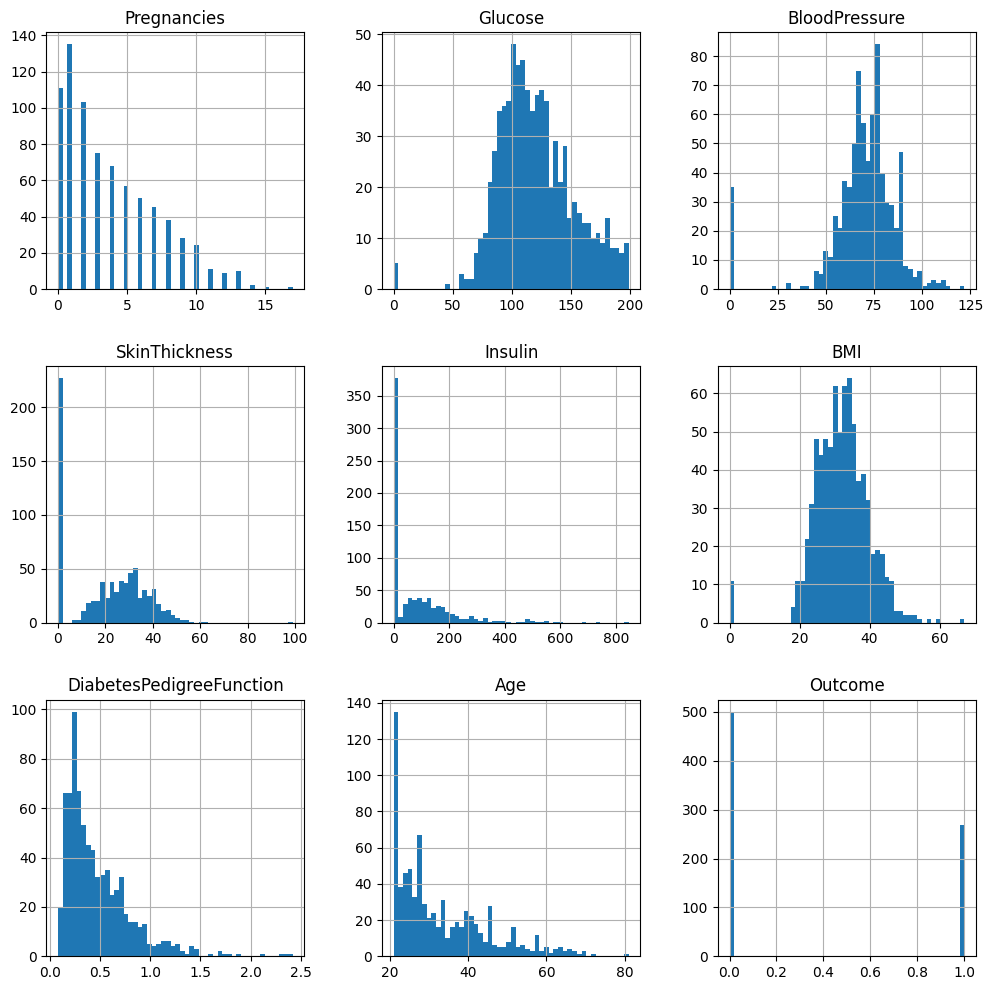

In [7]:
df.hist(figsize=(12,12), bins=50)
None

### Problem 1 Graded Answer

In [8]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape,X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics.  


**Note:** `sweep_parameter` sets `X_train` etc. to default values using the global values for `X_train` etc. you created in problem 1.  Should work fine as is, but you can always just ignore the defaults and assign the parameters explicitly. 


In [9]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [ ]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy = mean_cv_accuracy
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters, max_cv_accuracy, best_param


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000` using `run_model` or just your own code. 
- Answer the graded questions

In [11]:
# logistic regression default parameters
lr_params = {
    'class_weight': 'balanced',
    'max_iter': 1000,
    'random_state': random_state,
    'accuracy_found': float('-inf')
}

In [12]:
# Scale the feature data for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# sweep parameters of the logistic regression model
lr_mean_cv_accuracy, lr_std_cv_accuracy, lr_train_accuracy, lr_test_accuracy = run_model(LogisticRegression,X_train_scaled, y_train, X_test_scaled, y_test, n_repeats=10, n_jobs=-1, **lr_params)

### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [18]:
# Insert the mean CV accuracy

a2a = lr_mean_cv_accuracy              # Just to get it to run without errors, put your answer here                       

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7526


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [19]:
# Insert the test accuracy

a2b = lr_test_accuracy                 # Just to get it to run without errors, put your answer here                          

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.7143


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions and/or grid search as needed
- Answer the graded questions


In [23]:
# dictionary of default values for the gradient boosting model
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'max_features': None,
    'random_state': random_state,
    'accuracy_found': float('-inf')
}

In [28]:
# dictionary to store the best parameters
parameter_gb = {
    'random_state': random_state,
    'accuracy_found': float('-inf')
}

# create a list to hold accuracy values
accuracy_gb = []

Sweeping n_estimators: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


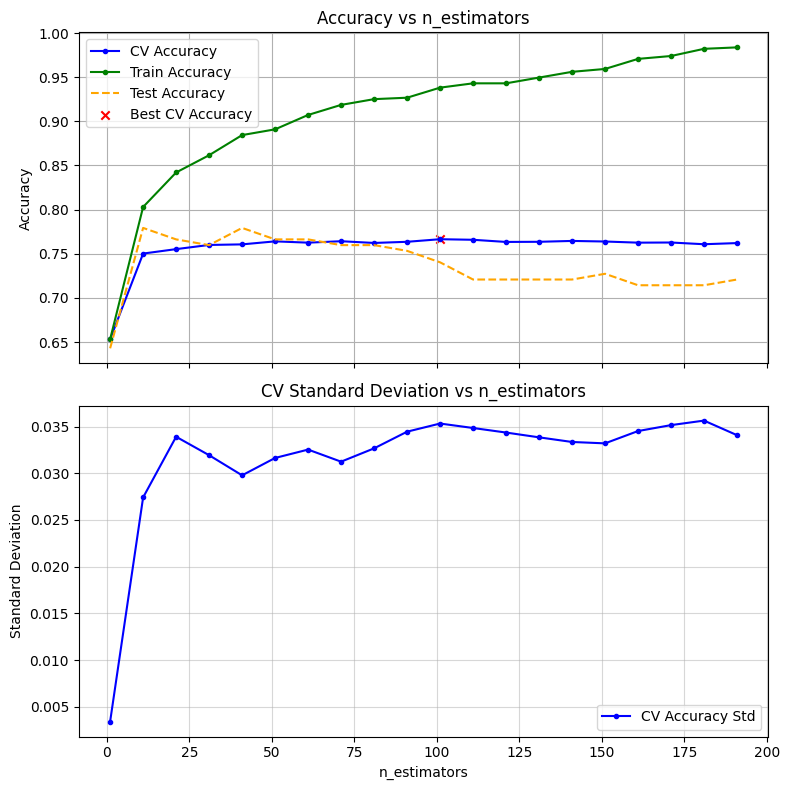

Execution Time: 00:00:24
Best number of estimators: 101
Best CV Accuracy: 0.766437425029988


In [32]:
# Your code here
# sweep parameters of the gradient boosting model
est_gb = sweep_parameter(GradientBoostingClassifier, gb_params, 'n_estimators', range(1, 201, 10))
est_acc = est_gb['accuracy_found']
est_best_param = est_gb['n_estimators']

# saving the best parameter value
parameter_gb['n_estimators'] = est_best_param

# saving the best rmse value
accuracy_gb.append(est_acc)

print("Best number of estimators:", est_best_param)
print("Best CV Accuracy:", est_acc)

Sweeping learning_rate: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


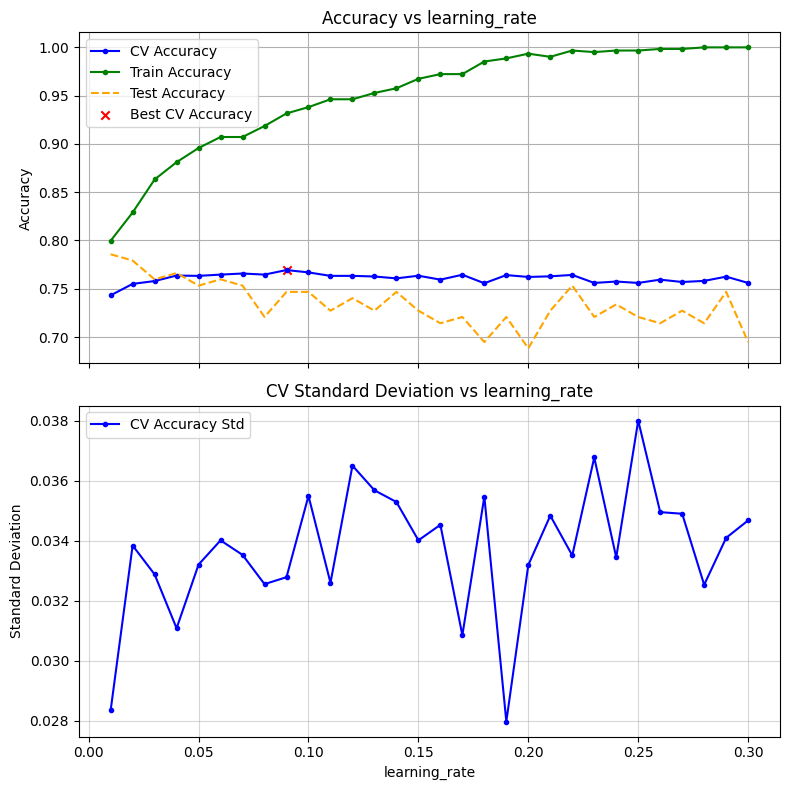

Execution Time: 00:00:33
Best learning rate: 0.08999999999999998
Best CV Accuracy: 0.7693695854991337


In [33]:
# Sweep the learning rate parameter
lr_gb = sweep_parameter(GradientBoostingClassifier, parameter_gb, 'learning_rate', np.linspace(0.01,0.3,30))
lr_acc = lr_gb['accuracy_found']
lr_best_param = lr_gb['learning_rate']

# saving the best parameter value
parameter_gb['learning_rate'] = lr_best_param

# saving the best accuracy value
accuracy_gb.append(lr_acc)

print("Best learning rate:", lr_best_param)
print("Best CV Accuracy:", lr_acc)

Sweeping max_depth: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it]


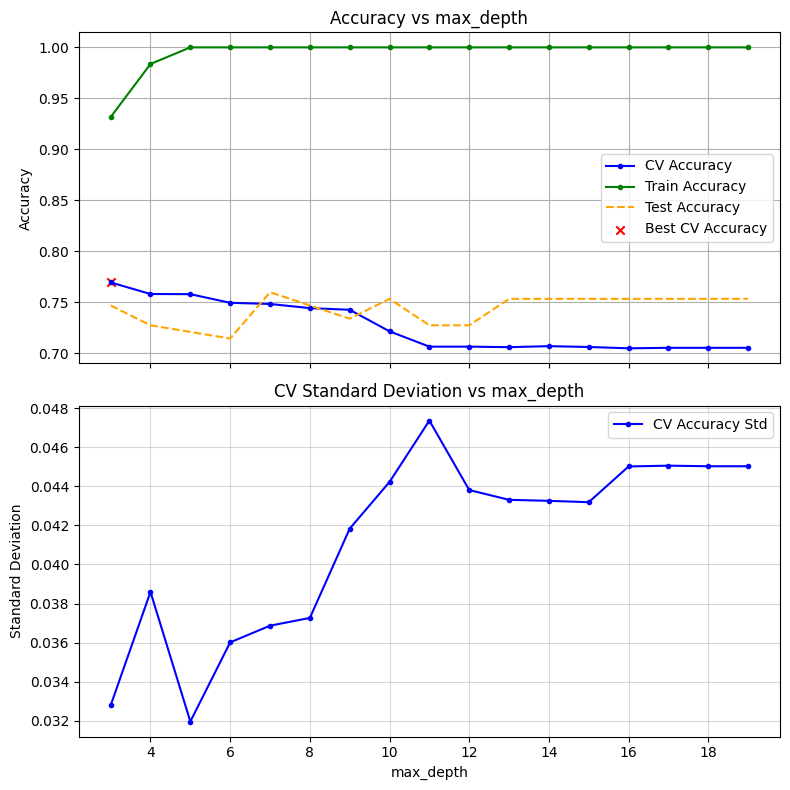

Execution Time: 00:01:13
Best Tree Depth: 3
Best CV Accuracy: 0.7693695854991337


In [34]:
# Sweep the max depth parameter
depth_gb = sweep_parameter(GradientBoostingClassifier, parameter_gb, 'max_depth', range(3,20))
depth_acc = depth_gb['accuracy_found']
depth_best_param = depth_gb['max_depth']

# saving the best parameter value
parameter_gb['max_depth'] = depth_best_param

# saving the best accuracy value
accuracy_gb.append(depth_acc)

print("Best Tree Depth:", depth_best_param)
print("Best CV Accuracy:", depth_acc)

In [35]:
parameter_gb

{'random_state': 42,
 'accuracy_found': -inf,
 'n_estimators': 101,
 'learning_rate': np.float64(0.08999999999999998),
 'max_depth': 3}

In [36]:
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

In [45]:
# Grid searh on the X_train and y_train data

# Record start time
start = time.time()

# Define the model
gb_model = GradientBoostingClassifier(random_state=random_state)

# Define the parameter grid
param_dist = {
    'n_estimators': range(90,110,1),
    'learning_rate': [.085, .086, .087, .088, .089, .09, .091, .092, .093, .094, .095, .096, .097, .098, .099, .01],
    'max_depth': [3]    # Fixed value                               
}

# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_dist,
    scoring='accuracy',  # MSE but negated for maximization by GridSearchCV
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42),  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Fit the GridSearchCV
search.fit(X_train, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_learning_rate',
    'param_max_depth',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_learning_rate': 'learning_rate',
        'param_max_depth': 'max_depth',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

# Best parameters and test performance
gb_grid_best_params = search.best_params_
print(f"\nBest Parameters: {gb_grid_best_params}")
gb_grid_cv_acc = search.best_score_
print(f"Best CV RMSE: {gb_grid_cv_acc:.4f}")

# Evaluate on the test set
y_pred_gb = search.best_estimator_.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_gb)

print(f"Test RMSE:    {test_acc:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))




Search Results (Top 5):

 n_estimators  learning_rate  max_depth  mean_cv_score  std_cv_score  mean_train_score  std_train_score
           99           0.09          3      -0.770672      0.035243         -0.945073         0.008275
          100           0.09          3      -0.770348      0.035105         -0.945805         0.008408
           98           0.09          3      -0.770019      0.036001         -0.944584         0.008243
           97           0.09          3      -0.769856      0.036380         -0.943607         0.008232
          101           0.09          3      -0.769531      0.033901         -0.946335         0.008336

Best Parameters: {'learning_rate': 0.09, 'max_depth': 3, 'n_estimators': 99}
Best CV RMSE: 0.7707
Test RMSE:    0.7532
Execution Time: 4m 38.13s


### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [46]:
# Insert the mean CV accuracy

a3a = gb_grid_cv_acc                   # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = 0.7707


### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [47]:
# Insert the test accuracy

a3b = test_acc                              # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = 0.7532
